<a href="https://colab.research.google.com/github/iu5git/ai-bot-games-in-js/blob/main/PingPongExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install onnxruntime==1.14.1
!pip install onnx==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 43.8 MB/s eta 0:00:00


In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import os

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

from sklearn.metrics import classification_report
from IPython.display import clear_output
from tqdm.auto import tqdm

import onnx
import onnxruntime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!gdown --id 1fgyvtdg6ShgXBvTZWQEBJGjKTjRATbSj
!gdown --id 11VhID0bod6neOfsUBkaYvkiEMVyr9Wjx
!gdown --id 1yZS6I7-j19HxVXuwD-2cOLv-SxDoGFsk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fgyvtdg6ShgXBvTZWQEBJGjKTjRATbSj
To: /content/ping_pong_dataset_40k.csv
100% 947k/947k [00:00<00:00, 130MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11VhID0bod6neOfsUBkaYvkiEMVyr9Wjx
To: /content/ping_pong_dataset_bot.csv
100% 4.02M/4.02M [00:00<00:00, 294MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: htt

In [ ]:
# Создание pandas Dataframe из csv файла
df = pd.read_csv('ping_pong_dataset_40k.csv')
# Три строки ниже можно раскомментировать, чтобы увеличить набор данных
# df2 = pd.read_csv('ping_pong_dataset_bot.csv')
# df3 = pd.read_csv('ping_pong_dataset.csv')
# df = pd.concat([df,df2,df3])

# Создание столбца содержащего положение мяча относительно ракетки по оси y
df['diff_y'] = df.ball_y - df.paddle_y
# Убираем по 1 персентилю записей с двух концов набора данных для положения мяча по оси X
df = df[df.ball_x.between(
    np.percentile(df.ball_x, 1),
    np.percentile(df.ball_x, 99))].copy()
# Вручную прописываем "правильные" 
df.loc[(df.ball_x>350) & (np.abs(df.diff_y) < 10), ['up','down','nothing']] = np.array([0,0,1])
df.loc[(df.ball_x>350) & (df.diff_y<-10), ['up','down','nothing']] = np.array([1,0,0,2])
df.loc[(df.ball_x>350) & (df.diff_y>10), ['up','down','nothing']] = np.array([0,1,0])
df.head()

1    38841
3     6025
2     5973
Name: action, dtype: int64


,ball_x,ball_y,paddle_y,up,down,nothing,action,diff_y
0,193,554.0,177,1,0,0,3,377.0
1,191,555.0,171,1,0,0,3,384.0
2,189,553.0,165,1,0,0,3,388.0
3,187,551.0,159,1,0,0,3,392.0
4,185,549.0,153,0,0,1,1,396.0


In [ ]:
# Аугментация. Дополняем набор данных записями, инвертированными по оси Y с добавлением шума
df_inv = df.copy()
# шум с нормальным распределением
noise = np.random.normal(scale=5, size=df_inv.shape[0])
# инвертирование положения мяча по оси Y
df_inv.ball_y = df_inv.ball_y.max() + df_inv.ball_y.min() - df_inv.ball_y + noise
# инвертирование положения ракетки по оси Y
df_inv.paddle_y = df_inv.paddle_y.max() + df_inv.paddle_y.min() - df_inv.paddle_y + noise
# замена действия "Вверх" на действие "Вниз" и наоборот
up = df_inv.down.values.copy()
down = df_inv.up.values.copy()
df_inv.up = up
df_inv.down = down
df_aug = pd.concat([df, df_inv])
# look-ahead
df_aug.up = df_aug.up.shift(-5)
df_aug.down = df_aug.down.shift(-5)
df_aug.nothing = df_aug.nothing.shift(-5)
# убираем пропуски данных
df_aug = df_aug.dropna()
print(df_aug.shape)

(99871, 8)


In [ ]:
# Создание набора входных данных и их меток
X = df_aug.loc[df_aug.ball_x>100, ['ball_x', 'ball_y', 'paddle_y']].values / 705 # нормализация
y = df_aug.loc[df_aug.ball_x>100, ['nothing', 'down', 'up']].values
print(X.shape, y.shape)

(92315, 3) (92315, 3)


### Создание Pytorch Dataloader

In [ ]:
# размер пакета данных обрабатываемых за одну итерацию
batch_size = 128
# создание Pytorch датасета
dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))\
# создание Pytorch даталоадера
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader

### Создание модели

In [ ]:
class PingPongModel(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.seq = nn.Sequential(
            # Первый скрытый слой с числом нейронов hidden_size и числом входов 3 (размер входных данных)
            nn.Linear(3, hidden_size),
            nn.ReLU(),
            # Второй скрытый слой с числом нейронов hidden_size//4 и числом входов, равным числу нейронов предыдущего слоя 
            nn.Linear(hidden_size, hidden_size//4),
            nn.ReLU(),
            # Выходной слой с числом нейронов равным числу выходных классов
            nn.Linear(hidden_size//4, 3),
            nn.Softmax(dim=1),
        )

    def forward(self, input):
        output = self.seq(input)
        return output

HIDDEN_SIZE = 256
model = PingPongModel(hidden_size=HIDDEN_SIZE)
model.to(device)
summary(model, input_size=(1, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           1,024
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 3]             195
           Softmax-6                 [-1, 1, 3]               0
Total params: 17,667
Trainable params: 17,667
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [ ]:
# Распределение весов классов для несбалансированной выборки
class_weights = torch.tensor([0.1, 1, 1], dtype=torch.float)
# Выбор функции потерь
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
# Выбор метода оптимизации
optimizer = optim.RMSprop(model.parameters(), lr=2e-3)

### Обучение модели

  0%|          | 0/28880 [00:00<?, ?it/s]

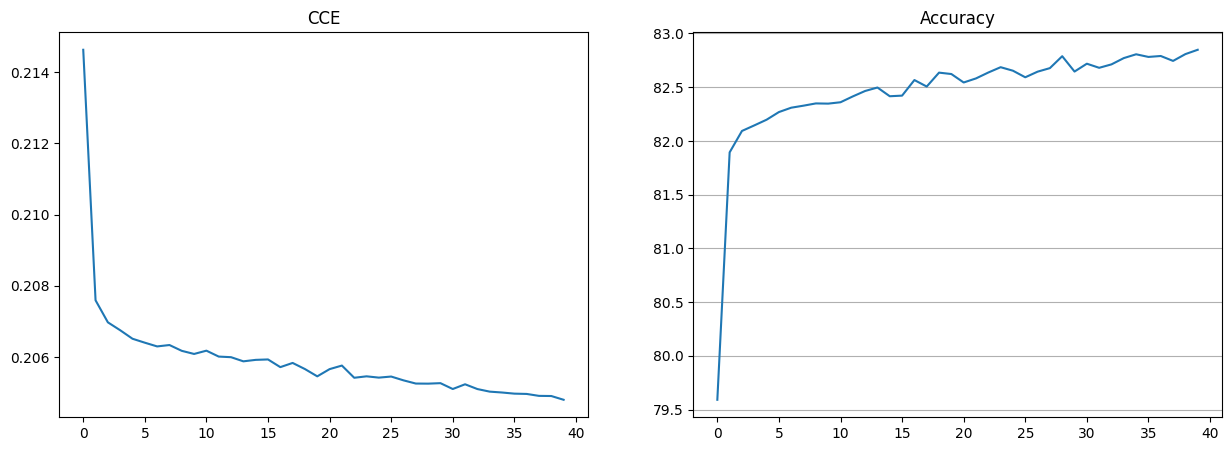

Обучение закончено


In [ ]:
EPOCHS = 40
REDRAW_EVERY = 5
steps_per_epoch = len(dataloader)
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
for epoch in range(EPOCHS): # проход по набору данных несколько раз
    model.train()
    tmp = []
    for i, batch in enumerate(dataloader, 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        # получение выходных значений нейронной сети
        outputs = model(inputs)
        # получение функции потерь
        loss = criterion(outputs, labels)
        # очищение прошлых градиентов с прошлой итерации   
        optimizer.zero_grad()
        # обратный проход
        loss.backward()
        # изменение значений параметров
        optimizer.step()
        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append(np.mean(tmp, axis=0))
    
    # Отрисовка графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, i])
        ax[i].set_title(title)
    plt.show()
    print('Обучение закончено')

### Проверка на оригинальных данных

In [ ]:
# получение трёх выходных столбцов из оригинальной выборки (метки)
orig_labels = df[['nothing', 'down', 'up']].values
# получение трёх входных столбцов из оригинальной выборки
orig_inputs = df[['ball_x', 'ball_y', 'paddle_y']].values
# получение выходных значение из нейронной сети
output = model(torch.Tensor(orig_inputs / 705).to(device)).detach().cpu().numpy()
# построение матрицы ошибок
confusion_matrix(orig_labels.argmax(-1), output.argmax(-1))

array([[19368,  1487,  3344],
       [  274, 11575,  4968],
       [  203,   103,  8616]])

### Проверка качества модели по классам

In [ ]:
y_pred = []
y_true = []
with torch.no_grad(): # отключение автоматического дифференцирования
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).detach().cpu().numpy()
        y_pred.append(outputs)
        y_true.append(labels.cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                digits=4, target_names=list(map(str, ['nothing', 'up', 'down']))))

              precision    recall  f1-score   support

     nothing     0.9758    0.7733    0.8628     40861
          up     0.8063    0.7408    0.7722     25729
        down     0.6717    0.9476    0.7862     25725

    accuracy                         0.8128     92315
   macro avg     0.8179    0.8206    0.8070     92315
weighted avg     0.8438    0.8128    0.8162     92315



### Сохранение модели в ONNX

In [ ]:
# входной тензор для модели
dummy_input  = torch.randn(1, 3, requires_grad=True).to(device)
torch_out = model(dummy_input )
# экспорт модели
torch.onnx.export(model, # модель
                  dummy_input, # входной тензор
                  "pingpong.onnx", # путь к файлу либо fileObject)
                  input_names = ['input'], # имя входного слоя
                  output_names = ['output'], # имя выходного слоя
                  dynamic_axes={ # динамичные оси, в данном случае только размер пакета
                      'input' : {0 : 'batch_size'},
                      'output' : {0 : 'batch_size'}
                      }
                  )

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# проверка работоспособности onnx файла
sess = onnxruntime.InferenceSession('pingpong.onnx')
print([(node.name, node.shape) for node in sess.get_inputs()])
sess.run(None, {'input': np.ones((1, 3), dtype=np.float32)})

[('input', ['batch_size', 3])]


[array([[0.        , 0.57839435, 0.42160568]], dtype=float32)]